In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.python.client import device_lib

import shap

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['svg.fonttype'] = 'none'
rcParams['font.size']=20
rcParams.update({'figure.autolayout': True})


import pandas as pd
import numpy as np
from scipy.stats import pearsonr

import py2bit

/home/eramamur/bin/miniconda3/envs/keras_tf_new_mar_18_2021/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ad_snp_list_and_info = pd.read_csv("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ad_variants_processing/common_variants/snigdha_snp_list_unique_haploreg_hg19_positions.txt",
                                sep='\t')

In [3]:
leftWindow = 499
rightWindow = 500

In [4]:
def oneHotEncodeSequence(sequence):
    oneHotDimension = (len(sequence), 4)
    dnaAlphabet = {"A":0, "G":1, "C":2, "T":3}    
    one_hot_encoded_sequence = np.zeros(oneHotDimension, dtype=int)
    for i, nucleotide in enumerate(sequence):
        if nucleotide.upper() in dnaAlphabet:
            index = dnaAlphabet[nucleotide.upper()]
            one_hot_encoded_sequence[i][index] = 1
    return one_hot_encoded_sequence


def getUpdatedPaddings(allele,left,right):
    alleleLength = len(allele)
    deductable = "right"
    for i in range(alleleLength-1):
        if deductable=="right":
            right-=1
            deductable="left"
        elif deductable=="left":
            left-=1
            deductable="right"

    return left,right

In [5]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False),
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [6]:
genome_object = py2bit.open("/home/eramamur/resources/genomes/hg19/hg19.2bit")

In [7]:
ref_sequences_list = []
alt_sequences_list = []

In [8]:
for i,row in ad_snp_list_and_info.iterrows():
    referenceLeftWindow, referenceRightWindow = getUpdatedPaddings(row["REF"], leftWindow, rightWindow)
    alternateLeftWindow, alternateRightWindow = getUpdatedPaddings(row["ALT"], leftWindow, rightWindow)

    referenceLeftSequence = genome_object.sequence(row["CHR"],
                                                   row["haploreg_hg19_pos"]-1-referenceLeftWindow,
                                                   row["haploreg_hg19_pos"]-1
                                                  )
    referenceRightSequence = genome_object.sequence(row["CHR"],
                                                    row["haploreg_hg19_pos"]-1+len(row["REF"]),
                                                    row["haploreg_hg19_pos"]-1+len(row["REF"])+referenceRightWindow
                                                   )
    referenceSequence = referenceLeftSequence.lower() + row["REF"].upper() + referenceRightSequence.lower()

    alternateLeftSequence = genome_object.sequence(row["CHR"],
                                                   row["haploreg_hg19_pos"]-1-alternateLeftWindow,
                                                   row["haploreg_hg19_pos"]-1
                                                  )
    alternateRightSequence = genome_object.sequence(row["CHR"],
                                                    row["haploreg_hg19_pos"]-1+len(row["REF"]),
                                                    row["haploreg_hg19_pos"]-1+len(row["REF"])+alternateRightWindow
                                                   )
    alternateSequence = alternateLeftSequence.lower() + row["ALT"].upper() + alternateRightSequence.lower()
    ref_sequences_list.append(referenceSequence)
    alt_sequences_list.append(alternateSequence)

In [9]:
microglia_overlap_info = np.loadtxt("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ad_variants_processing/common_variants/snigdha_snp_list_unique_gosselin_microglia_exvivo_idr_optimal_peak_liftover_hg38_to_hg19_overlap.simp.txt",
                                    dtype='int'
                                   )
monocyte_overlap_info = np.loadtxt("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ad_variants_processing/common_variants/snigdha_snp_list_unique_encode_monocyte_dhs_optimal_peak_liftover_hg38_to_hg19_overlap.simp.txt",
                                   dtype='int'
                                  )
neuron_overlap_info = np.loadtxt("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ad_variants_processing/common_variants/snigdha_snp_list_unique_fullard_neun_put_idr_optimal_peak_liftover_hg38_to_hg19_overlap.simp.txt",
                                 dtype='int'
                                )

In [10]:
ad_snp_list_and_info["REF_sequence_1kb"] = ref_sequences_list
ad_snp_list_and_info["ALT_sequence_1kb"] = alt_sequences_list
ad_snp_list_and_info["Microglia_overlap"] = microglia_overlap_info
ad_snp_list_and_info["Monocyte_overlap"] = monocyte_overlap_info
ad_snp_list_and_info["Neuron_overlap"] = neuron_overlap_info

In [11]:
monocyte_regression = load_model("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_monocyte/model_8_tf.hdf5", compile = False)

In [12]:
e = shap.DeepExplainer(monocyte_regression, np.zeros((10,1000,4)))

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


In [13]:
sig_snps = ["rs636317",
            "rs1010322",
            "rs2526377",
            "rs76726049",
            "rs9270921",
            "rs9271182",
            "rs28834970",
            "rs6064392",
            "rs9271162",
            "rs395601"
           ]

In [14]:
sig_snps_info = ad_snp_list_and_info.loc[ad_snp_list_and_info["LD_RSID"].isin(sig_snps)]

In [15]:
sig_snps_info

,CHR,haploreg_hg19_pos,LD_RSID,REF,ALT,REF_sequence_1kb,ALT_sequence_1kb,Microglia_overlap,Monocyte_overlap,Neuron_overlap
178,chr11,60019150,rs636317,C,T,gtgtgtgtgtgtgtctctgccagattttggtatcaggatgatgctg...,gtgtgtgtgtgtgtctctgccagattttggtatcaggatgatgctg...,1,1,0
407,chr15,59063196,rs395601,G,C,tcccactccatgcaaagtgaagccaagttagcaaaaccgcaaagac...,tcccactccatgcaaagtgaagccaagttagcaaaaccgcaaagac...,1,1,1
451,chr17,47338083,rs1010322,C,G,gatccgccgcgacacagcagctattcagacgtcgggggcgggggcc...,gatccgccgcgacacagcagctattcagacgtcgggggcgggggcc...,1,1,0
562,chr17,56410041,rs2526377,A,G,gagacactggtcccacttctcagcctctgcgtaccctctgccatcc...,gagacactggtcccacttctcagcctctgcgtaccctctgccatcc...,1,1,0
579,chr18,56189459,rs76726049,T,C,agccattctcttgcctcagcctcctgagtagctgggattacaggtg...,agccattctcttgcctcagcctcctgagtagctgggattacaggtg...,0,1,0
632,chr20,54984768,rs6064392,G,T,tttttgtattttttgtagagatggggcttcgccatgttagccaggc...,tttttgtattttttgtagagatggggcttcgccatgttagccaggc...,1,1,0
889,chr6,32572326,rs9270921,C,T,gttaggctagagactcgccggggaacaggaactatcatgaataaca...,gttaggctagagactcgccggggaacaggaactatcatgaataaca...,0,1,0
1012,chr6,32577715,rs9271162,G,T,gtaggaggcgtagagaaaatataatgaaacgatatgtaagggaaac...,gtaggaggcgtagagaaaatataatgaaacgatatgtaagggaaac...,1,1,1
1025,chr6,32578230,rs9271182,A,G,ctccaaccaataggaatagagaatgaggcagcatcacttgtctcca...,ctccaaccaataggaatagagaatgaggcagcatcacttgtctcca...,0,1,0
1184,chr8,27195121,rs28834970,T,C,tttagtacgttcacagagttgtgcaaccatcaccgctttttttctt...,tttagtacgttcacagagttgtgcaaccatcaccgctttttttctt...,0,1,0


In [16]:
rs76726049_ref_seq_1kb = oneHotEncodeSequence(sig_snps_info.loc[sig_snps_info["LD_RSID"]=="rs76726049"]["REF_sequence_1kb"].item())
rs76726049_alt_seq_1kb = oneHotEncodeSequence(sig_snps_info.loc[sig_snps_info["LD_RSID"]=="rs76726049"]["ALT_sequence_1kb"].item())

rs76726049_ref_alt_seq_1kb_pair = np.array([rs76726049_ref_seq_1kb, rs76726049_alt_seq_1kb])

In [17]:
rs636317_ref_seq_1kb = oneHotEncodeSequence(sig_snps_info.loc[sig_snps_info["LD_RSID"]=="rs636317"]["REF_sequence_1kb"].item())
rs636317_alt_seq_1kb = oneHotEncodeSequence(sig_snps_info.loc[sig_snps_info["LD_RSID"]=="rs636317"]["ALT_sequence_1kb"].item())

rs636317_ref_alt_seq_1kb_pair = np.array([rs636317_ref_seq_1kb, rs636317_alt_seq_1kb])

In [18]:
rs76726049_shap_values = e.shap_values(rs76726049_ref_alt_seq_1kb_pair)
rs636317_shap_values = e.shap_values(rs636317_ref_alt_seq_1kb_pair)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


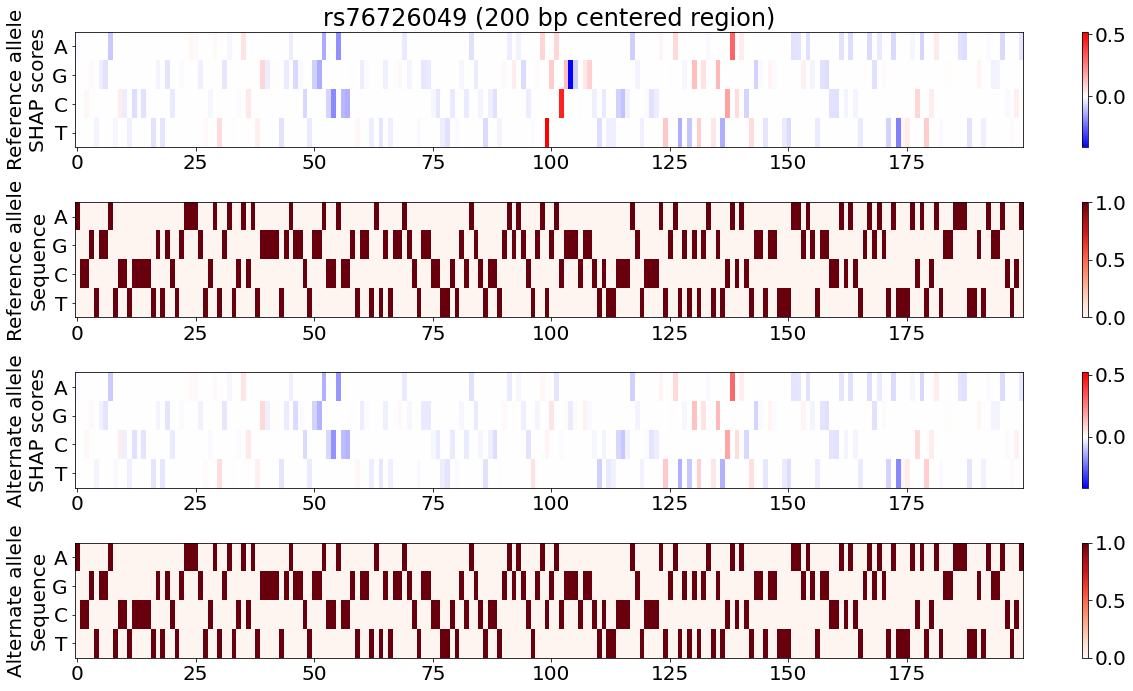

In [19]:
fig,ax=plt.subplots(4,1)
fig.set_figheight(10)
fig.set_figwidth(18)

vmin = np.amin(rs76726049_shap_values[0][:,400:600,:].T)
vmax = np.amax(rs76726049_shap_values[0][:,400:600,:].T)
vmid = 1 - vmax / (vmax + abs(vmin))
new_cmap = shiftedColorMap(matplotlib.cm.bwr, midpoint=vmid, name='shrunk')

ax[0].set_title("rs76726049 (200 bp centered region)")

im = ax[0].imshow(rs76726049_shap_values[0][0,400:600,:].T, aspect="auto", cmap=new_cmap, vmax=vmax, vmin=vmin)
ax[0].set_ylabel("Reference allele\nSHAP scores")
ax[0].figure.colorbar(im, ax=ax[0])
ax[0].set_yticks(range(len(["A", "G", "C", "T"])))
ax[0].set_yticklabels(["A", "G", "C", "T"])
im = ax[1].imshow(rs76726049_ref_alt_seq_1kb_pair[0,400:600,:].T, aspect="auto", cmap="Reds")
ax[1].set_ylabel("Reference allele\nSequence")
ax[1].figure.colorbar(im, ax=ax[1])
ax[1].set_yticks(range(len(["A", "G", "C", "T"])))
ax[1].set_yticklabels(["A", "G", "C", "T"])
im = ax[2].imshow(rs76726049_shap_values[0][1,400:600,:].T, aspect="auto", cmap=new_cmap, vmax=vmax, vmin=vmin)
ax[2].set_ylabel("Alternate allele\nSHAP scores")
ax[2].figure.colorbar(im, ax=ax[2])
ax[2].set_yticks(range(len(["A", "G", "C", "T"])))
ax[2].set_yticklabels(["A", "G", "C", "T"])
im = ax[3].imshow(rs76726049_ref_alt_seq_1kb_pair[1,400:600,:].T, aspect="auto", cmap="Reds")
ax[3].set_ylabel("Alternate allele\nSequence")
ax[3].figure.colorbar(im, ax=ax[3])
ax[3].set_yticks(range(len(["A", "G", "C", "T"])))
ax[3].set_yticklabels(["A", "G", "C", "T"])


plt.savefig("rs76726049_shap_contributions_middle_200_bp.svg")

In [20]:
monocyte_regression.predict(rs76726049_ref_alt_seq_1kb_pair)

array([[6.5130463],
       [5.6627464]], dtype=float32)

In [21]:
sig_snps_info.loc[sig_snps_info["LD_RSID"]=="rs76726049"]["REF_sequence_1kb"].item()[490:510]

'gagagctgaTgacgggcggc'

In [22]:
sig_snps_info.loc[sig_snps_info["LD_RSID"]=="rs76726049"]["ALT_sequence_1kb"].item()[490:510]

'gagagctgaCgacgggcggc'

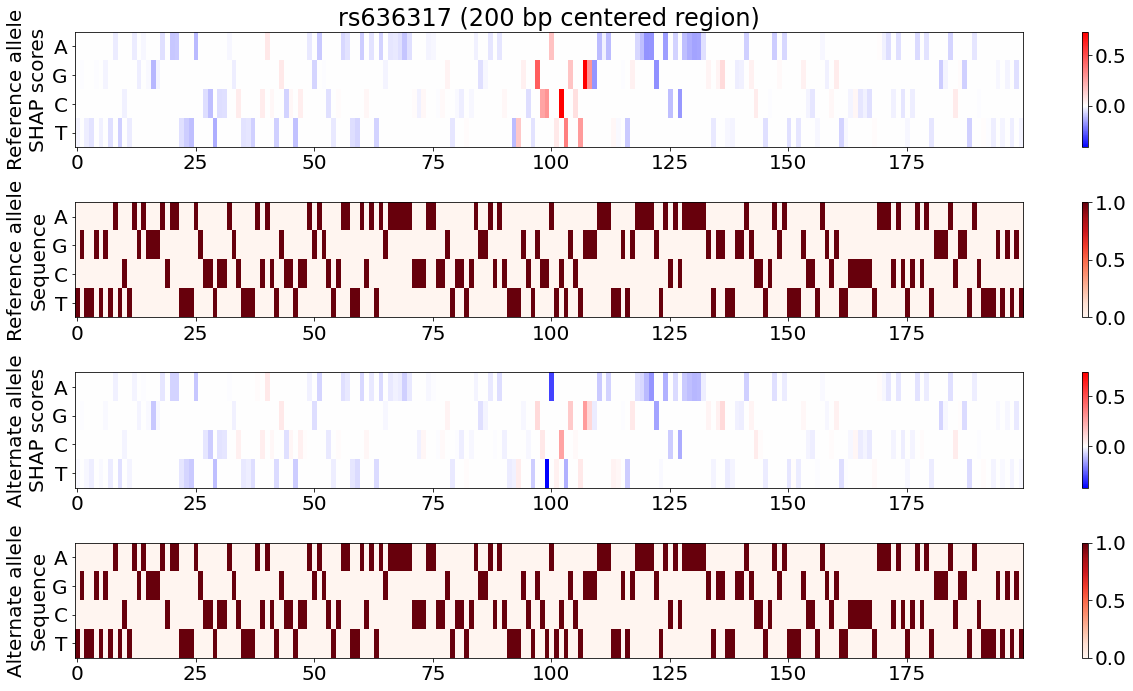

In [23]:
fig,ax=plt.subplots(4,1)
fig.set_figheight(10)
fig.set_figwidth(18)

vmin = np.amin(rs636317_shap_values[0][:,400:600,:].T)
vmax = np.amax(rs636317_shap_values[0][:,400:600,:].T)
vmid = 1 - vmax / (vmax + abs(vmin))
new_cmap = shiftedColorMap(matplotlib.cm.bwr, midpoint=vmid, name='shrunk')

ax[0].set_title("rs636317 (200 bp centered region)")

im = ax[0].imshow(rs636317_shap_values[0][0,400:600,:].T, aspect="auto", cmap=new_cmap, vmax=vmax, vmin=vmin)
ax[0].set_ylabel("Reference allele\nSHAP scores")
ax[0].figure.colorbar(im, ax=ax[0])
ax[0].set_yticks(range(len(["A", "G", "C", "T"])))
ax[0].set_yticklabels(["A", "G", "C", "T"])
im = ax[1].imshow(rs636317_ref_alt_seq_1kb_pair[0,400:600,:].T, aspect="auto", cmap="Reds")
ax[1].set_ylabel("Reference allele\nSequence")
ax[1].figure.colorbar(im, ax=ax[1])
ax[1].set_yticks(range(len(["A", "G", "C", "T"])))
ax[1].set_yticklabels(["A", "G", "C", "T"])
im = ax[2].imshow(rs636317_shap_values[0][1,400:600,:].T, aspect="auto", cmap=new_cmap, vmax=vmax, vmin=vmin)
ax[2].set_ylabel("Alternate allele\nSHAP scores")
ax[2].figure.colorbar(im, ax=ax[2])
ax[2].set_yticks(range(len(["A", "G", "C", "T"])))
ax[2].set_yticklabels(["A", "G", "C", "T"])
im = ax[3].imshow(rs636317_ref_alt_seq_1kb_pair[1,400:600,:].T, aspect="auto", cmap="Reds")
ax[3].set_ylabel("Alternate allele\nSequence")
ax[3].figure.colorbar(im, ax=ax[3])
ax[3].set_yticks(range(len(["A", "G", "C", "T"])))
ax[3].set_yticklabels(["A", "G", "C", "T"])


plt.savefig("rs636317_shap_contributions_middle_200_bp.svg")

In [23]:
monocyte_regression.predict(rs636317_ref_alt_seq_1kb_pair)

array([[7.8848634],
       [5.5845947]], dtype=float32)

In [24]:
sig_snps_info.loc[sig_snps_info["LD_RSID"]=="rs636317"]["REF_sequence_1kb"].item()[490:510]

'ctttgctgcCatctgctggg'

In [25]:
sig_snps_info.loc[sig_snps_info["LD_RSID"]=="rs636317"]["ALT_sequence_1kb"].item()[490:510]

'ctttgctgcTatctgctggg'